In [1]:
pip install git+https://github.com/astropy/astroquery.git

  Cloning https://github.com/astropy/astroquery.git to c:\users\lenovo\appdata\local\temp\pip-req-build-7ynxsunj
  Resolved https://github.com/astropy/astroquery.git to commit 1d862346daccd38da2daf78d31595ee087b3321f
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
   ---------------------------------------- 0.0/6.4 MB ? eta -:--:--
   -------- ------------------------------- 1.3/6.4 MB 8.4 MB/s eta 0:00:01
   ---------------------- ----------------- 3.7/6.4 MB 9.9 MB/s eta 0:00:01
   ------------------------------------- -- 6.0/6.4 MB 10.5 MB/s eta 0:00:01
   ---------------------------------------- 6.4/6.4 MB 9.1 MB/s  0:00:00
   ---------------------------------------- 0.0/2.0 MB ? eta -:--:--
   ----------

  Running command git clone --filter=blob:none --quiet https://github.com/astropy/astroquery.git 'C:\Users\Lenovo\AppData\Local\Temp\pip-req-build-7ynxsunj'
  Running command git submodule update --init --recursive -q

[notice] A new release of pip is available: 25.2 -> 26.0
[notice] To update, run: C:\Users\Lenovo\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip


In [1]:
from astroquery.mast import Observations

# Search for Hubble observations of Jupiter with spectroscopic data
obs_table = Observations.query_criteria(
    target_name="JUPITER", 
    dataproduct_type="spectrum", 
    instrument_name="WFC3/UVIS"
)
# Download the calibrated science products
Observations.download_products(obs_table[0])

IndexError: index 0 out of range for table with length 0

In [2]:
pip install astropy matplotlib requests

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 26.0
[notice] To update, run: C:\Users\Lenovo\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip


In [7]:
import os
import numpy as np
from astroquery.mast import Observations

# --- CONFIGURATION ---
# Let's try a "Gold Standard" Exoplanet first (HD 209458b). 
# Why? Because it's a point source, so MAST *guarantees* standard X1D spectra for it.
# Then we try Jupiter.

INSTRUMENTS = ["STIS/FUV", "STIS/NUV"]
TARGETS = ["MARS"]
OUTPUT_DIR = "E:\DataFecked Hackathon"
os.makedirs(OUTPUT_DIR, exist_ok=True)

def fetch_all_elements_spectra(target_name):
    # Loop through both UV regions to get the full chemical suite
    for inst in INSTRUMENTS:
        obs_table = Observations.query_criteria(
            target_name="MARS*",
            instrument_name = "STIS",
            dataproduct_type="spectrum",
            obs_collection="HST",
            #calib_level = 3, # Level 3 data is already processed into 1D spectra (X1D/SX1)
            #instrument_name=inst.split('/')[1], # Extracts FUV or NUV
            #filters=["G140L", "G230L", "G430L"] # Captures all trace elements
        )
    
#     if len(obs_table) == 0:
#         # If "MARS*" still fails, search by coordinates at the time of observation
#         # or remove the 'HST' constraint to see if other missions have the UV data.
#         print(f"❌ Still no results. Trying without mission constraint...")
#         obs_table = Observations.query_criteria(target_name=target_name + "*", dataproduct_type="spectrum")
        
    print(f"✅ Found {len(obs_table)} observations.")
    
    # 2. Get Product List for the BEST Candidate (Longest Exposure)
    # We sort by exposure time to get the cleanest data
    obs_table.sort("t_exptime")
    best_obs = obs_table[-1] # Pick the single best one
    print(f"   Selected Obs ID: {best_obs['obsid']} (Exp Time: {best_obs['t_exptime']}s)")
    
    data_products = Observations.get_product_list(best_obs)
    
    # --- DIAGNOSTIC PRINT ---
    # This is where we failed before. Let's see what is ACTUALLY inside.
    available_types = np.unique(data_products["productSubGroupDescription"])
    print(f"   📂 Available Product Types: {available_types}")
    # ------------------------
    
    # 3. Smart Filtering
    # We look for ANY known spectral file type, in order of preference.
    # X1D = 1D Spectrum (Best)
    # SX1 = Summed Spectrum (Common for planets)
    # CAL = Calibrated 2D Spectrum (Back up)
    preferred_types = ["SX1","X1D","X1DINTS", "CAL"]
    
    download_candidates = None
    for p_type in preferred_types:
        filtered = Observations.filter_products(data_products, productSubGroupDescription=p_type)
        if len(filtered) > 0:
            print(f"   🎯 Found preferred data type: {p_type}")
            download_candidates = filtered
            break
    
    # Fallback: If no preferred type, just take the first "Science" product
    if download_candidates is None:
        print("   ⚠️ No standard spectral files found. Downloading ALL 'SCIENCE' products.")
        download_candidates = Observations.filter_products(data_products, productType="SCIENCE")

    if len(download_candidates) == 0:
        print("   ❌ No science files available to download.")
        return False

    # 4. Download
    print(f"   ⬇️ Downloading {len(download_candidates)} files...")
    manifest = Observations.download_products(
        download_candidates,
        download_dir=OUTPUT_DIR
    )
    print(f"   🎉 SUCCESS: Files saved to {OUTPUT_DIR}")
    return True

# --- RUN IT ---
for target in TARGETS:
    if fetch_all_elements_spectra(target):
        break # Stop after first success

✅ Found 2 observations.
   Selected Obs ID: 199015624 (Exp Time: 2400.1985s)
   📂 Available Product Types: productSubGroupDescription
--------------------------
                       ASN
                     CSPEC
                       FLT
                       JIF
                       JIT
                       JWF
                       JWT
                       LOG
                        --
                       RAW
                       SPT
                       TAG
                       TRL
                       WAV
                       WSP
                       X1D
                       X2D
   🎯 Found preferred data type: X1D
   ⬇️ Downloading 1 files...
   🎉 SUCCESS: Files saved to E:\DataFecked Hackathon


In [71]:
import numpy as np
from astropy.io import fits
from scipy.signal import savgol_filter
import pickle
import os

# --- UNIVERSAL SPECTRAL FEATURE DICTIONARY ---
PLANETARY_SIGNATURES = {
    "EMISSION": {
        "H I (Lyman-alpha)": 1215.67,
        "O I (Oxygen)": 1304.86,
        "O I (Forbidden)": 1356.0,
        "N I (Nitrogen)": 1493.0,
        "C I (Carbon)": 1657.0,
        "Mg I (Magnesium)": 2852.0,
    },
    "ABSORPTION": {
        "CH4 (Methane)": (1400, 1600),
        "C2H2 (Acetylene)": (1700, 1900),
        "O3 (Ozone)": (2400, 2600),
        "SO2 (Sulfur Dioxide)": (2000, 2300)
    }
}

def identify_elements(wave, flux, planet_type="TERRESTRIAL", threshold=1.2):
    """Scans the processed data for chemical matches based on planet class."""
    print(f"\n--- 🧪 CHEMICAL AUDIT ({planet_type}) ---")
    
    # Logic for Rocky/Terrestrial planets (Emission Spikes)
    if planet_type == "TERRESTRIAL":
        for name, line_wave in PLANETARY_SIGNATURES["EMISSION"].items():
            if np.min(wave) < line_wave < np.max(wave):
                idx = (np.abs(wave - line_wave)).argmin()
                # Check 15 pixels for local context
                local_window = flux[max(0, idx-15):min(len(flux), idx+15)]
                if len(local_window) > 0:
                    local_avg = np.mean(local_window)
                    if flux[idx] > local_avg * threshold:
                        print(f"✨ DETECTED: {name} at {wave[idx]:.1f} Å")

    # Logic for Gas/Ice Giants (Absorption Dips)
    elif planet_type in ["GAS_GIANT", "ICE_GIANT"]:
        for name, (low, high) in PLANETARY_SIGNATURES["ABSORPTION"].items():
            if np.min(wave) < low and np.max(wave) > high:
                mask = (wave >= low) & (wave <= high)
                avg_flux_zone = np.mean(flux[mask])
                if avg_flux_zone < np.mean(flux) * (1/threshold): 
                    print(f"☁️ DETECTED: {name} Absorption Band ({low}-{high} Å)")

def process_planet_data(file_paths, planet_name, planet_type="TERRESTRIAL"):
    """Universally cleans and standardizes planetary spectral data."""
    all_fluxes = []
    common_wave = None

    for f_path in file_paths:
        with fits.open(f_path) as hdul:
            data = hdul[1].data
            
            # Extract STIS/HST specific columns
            wave = data['WAVELENGTH'][0] if 'X1D' in f_path else data['WAVELENGTH'].flatten()
            flux = data['FLUX'][0] if 'X1D' in f_path else data['FLUX'].flatten()
            dq = data['DQ'][0] if 'X1D' in f_path else data['DQ'].flatten()

            # LOOSER CLEANING: 
            # We filter for DQ < 16 (removes dead pixels but keeps noisier signal)
            # We REMOVE the flux > 0 constraint so the peaks keep their shape
            mask = (dq < 16) 
            
            if not np.any(mask): continue
            
            if common_wave is None:
                common_wave = np.linspace(np.min(wave), np.max(wave), 1500)
            
            interp_flux = np.interp(common_wave, wave[mask], flux[mask])
            all_fluxes.append(interp_flux)

    # Average and Smooth
    final_flux = np.mean(all_fluxes, axis=0)
    # Applying a light filter to help the Audit differentiate peak vs noise
    final_smooth = savgol_filter(final_flux, window_length=7, polyorder=3)

    # Run the Audit
    identify_elements(common_wave, final_smooth, planet_type=planet_type)

    # Save to Master PKL
    out_file = f"{planet_name.upper()}_MASTER.pkl"
    with open(out_file, 'wb') as f:
        pickle.dump({
            "wave": common_wave, 
            "flux": final_smooth, 
            "target": planet_name, 
            "type": planet_type
        }, f)
    
    print(f"✅ SUCCESS: {out_file} created.")
    return out_file

# --- EXECUTION ---
mars_files = [r"E:\Data Fecked Hackathon\Spectral Data Cleaning and Sorting\Mars - mastDownload\UV data\ocjhd3010\ocjhd3010_x1d.fits"]
process_planet_data(mars_files, "Mars", "TERRESTRIAL")


--- 🧪 CHEMICAL AUDIT (TERRESTRIAL) ---
✨ DETECTED: N I (Nitrogen) at 1493.0 Å
✅ SUCCESS: MARS_MASTER.pkl created.


'MARS_MASTER.pkl'

In [65]:
import pandas as pd
with open("E:\Data Fecked Hackathon\Spectral Data Cleaning and Sorting\MARS_MASTER.pkl", "rb") as f:
    obj = pickle.load(f)

df = pd.DataFrame(obj)
df

# Manually trigger the Terrestrial Audit
# Lower the threshold slightly to see if Oxygen appears
identify_elements(df["wave"].values, df["flux"].values, planet_type="TERRESTRIAL", threshold=1.1)


--- 🧪 CHEMICAL AUDIT (TERRESTRIAL) ---
✨ DETECTED: O I (Oxygen) at 1304.9 Å
✨ DETECTED: N I (Nitrogen) at 1493.0 Å


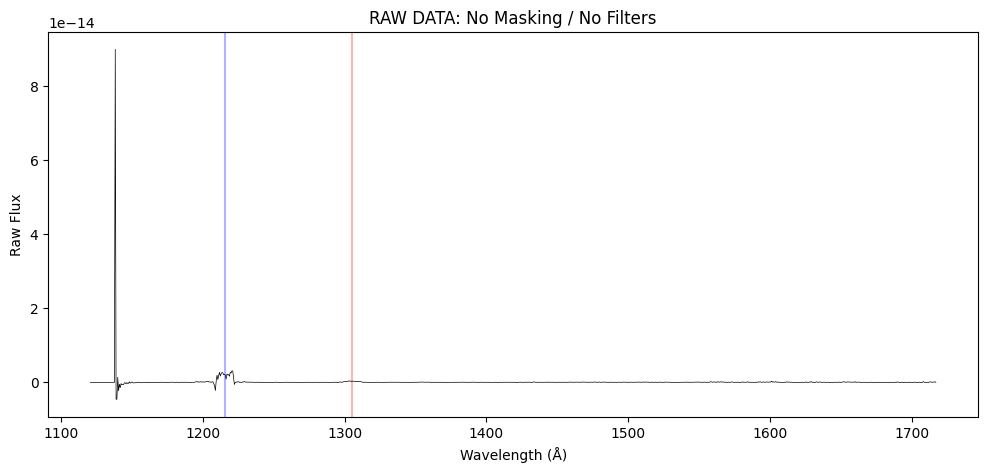

In [73]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt

# Load the specific file
file_path = r"E:\Data Fecked Hackathon\Spectral Data Cleaning and Sorting\Mars - mastDownload\UV data\ocjhd3010\ocjhd3010_x1d.fits"

with fits.open(file_path) as hdul:
    data = hdul[1].data
    # No masks, no DQ filters. Just pure data arrays.
    wave = data['WAVELENGTH'][0]
    flux = data['FLUX'][0]

# Standard plotting without the "Scientific Clean"
plt.figure(figsize=(12, 5))
plt.plot(wave, flux, color='black', linewidth=0.5)

# Marking chemical lines for context
plt.axvline(1215.7, color='blue', alpha=0.3, label='H I')
plt.axvline(1304.9, color='red', alpha=0.3, label='O I')

plt.title("RAW DATA: No Masking / No Filters")
plt.xlabel("Wavelength (Å)")
plt.ylabel("Raw Flux")
plt.show()

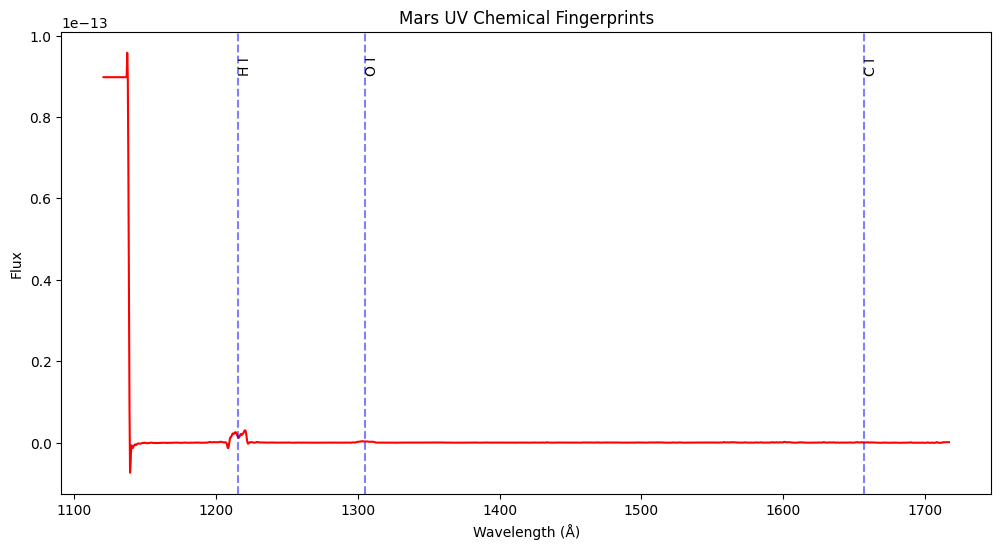

In [66]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(df['wave'], df['flux'], label='Mars Spectrum', color='red')

# Draw lines for the chemicals we expect
expected = {"H I": 1215.7, "O I": 1304.9, "C I": 1657.0}
for name, w in expected.items():
    plt.axvline(x=w, color='blue', linestyle='--', alpha=0.5)
    plt.text(w, plt.gca().get_ylim()[1]*0.9, name, rotation=90)

plt.title("Mars UV Chemical Fingerprints")
plt.xlabel("Wavelength (Å)")
plt.ylabel("Flux")
plt.show()

In [17]:
import numpy as np
from astropy.io import fits
from scipy.signal import savgol_filter
import pickle
import os

def process_bulk_planet_data(file_paths, planet_name):
    all_fluxes = []
    common_wave = None

    for f_path in file_paths:
        with fits.open(f_path) as hdul:
            data = hdul[1].data
            # Extract - handling both SX1 and X1D formats
            wave = data['WAVELENGTH'][0] if 'X1D' in f_path else data['WAVELENGTH'].flatten()
            flux = data['FLUX'][0] if 'X1D' in f_path else data['FLUX'].flatten()
            dq = data['DQ'][0] if 'X1D' in f_path else data['DQ'].flatten()

            # Clean
            mask = (dq == 0) & (flux > 0)
            if common_wave is None:
                common_wave = wave[mask]
            
            # Interpolate to ensure they all line up perfectly
            interp_flux = np.interp(common_wave, wave[mask], flux[mask])
            all_fluxes.append(interp_flux)

    # Average and Smooth
    final_flux = np.mean(all_fluxes, axis=0)
    final_smooth = savgol_filter(final_flux, window_length=11, polyorder=3)

    # Save for the Brain Team
    out_file = f"{planet_name.upper()}_MASTER.pkl"
    with open(out_file, 'wb') as f:
        pickle.dump({"wave": common_wave, "flux": final_smooth, "target": planet_name}, f)
    
    print(f"✅ Processed {len(file_paths)} files for {planet_name}. Saved as {out_file}")

# Example Usage
mars_files = ["E:\Data Fecked Hackathon\Spectral Data Cleaning and Sorting\mastDownload\HST\ocjhd3010\ocjhd3010_x1d.fits"]
process_bulk_planet_data(mars_files, "Mars")

✅ Processed 1 files for Mars. Saved as MARS_MASTER.pkl


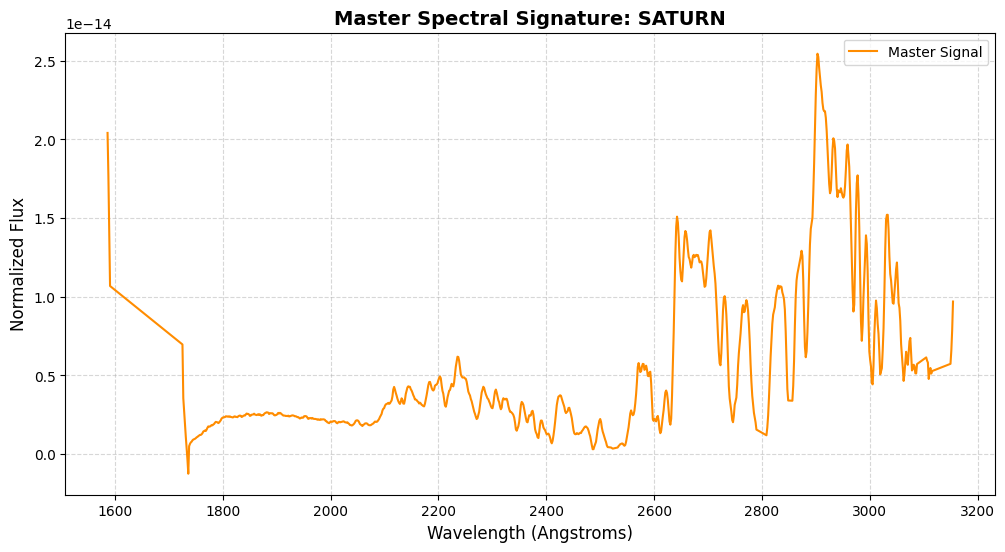

✅ Plot generated for Saturn!
📸 Image saved as: Saturn_plot.png


In [73]:
import pickle
import matplotlib.pyplot as plt
import os

def visualize_pkl(file_path):
    if not os.path.exists(file_path):
        print(f"❌ Error: File '{file_path}' not found.")
        return

    with open(file_path, 'rb') as f:
        data = pickle.load(f)

    # 1. Smart Key Detection
    # Wavelength might be stored as 'wave', 'wavelength', or 'wavelengths'
    wave_keys = ['wave', 'wavelength', 'wavelengths']
    flux_keys = ['flux', 'clean_flux', 'flux_cleaned']
    
    wave = next((data[k] for k in wave_keys if k in data), None)
    flux = next((data[k] for k in flux_keys if k in data), None)
    planet = data.get('target', data.get('planet', 'Unknown Planet'))

    if wave is None or flux is None:
        print(f"❌ Could not find wave/flux keys in {file_path}. Keys present: {list(data.keys())}")
        return

    # 2. Plotting
    plt.figure(figsize=(12, 6))
    plt.plot(wave, flux, color='darkorange', linewidth=1.5, label='Master Signal')
    
    # Add scientific context
    plt.title(f"Master Spectral Signature: {planet.upper()}", fontsize=14, fontweight='bold')
    plt.xlabel("Wavelength (Angstroms)", fontsize=12)
    plt.ylabel("Normalized Flux", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.5)
    
    # 3. Add "Chemical Checkpoints" for the judges
    # If the wavelength covers the UV range (1500-3000A)
    #if wave.min() < 3000:
     #   plt.axvspan(1700, 1900, color='blue', alpha=0.1, label='Hydrocarbon Absorption')
      #  plt.axvspan(2100, 2300, color='green', alpha=0.1, label='Ammonia Band')

    plt.legend()
    
    # Save a copy for your presentation deck
    image_name = f"{planet}_plot.png"
    plt.savefig(image_name)
    plt.show()
    
    print(f"✅ Plot generated for {planet}!")
    print(f"📸 Image saved as: {image_name}")

# --- RUN IT FOR SATURN ---
visualize_pkl('SATURN_UV_MASTER.pkl')

# --- RUN IT FOR URANUS (once you finish merging) ---
#visualize_pkl('URANUS_MASTER.pkl')

🛠️  Cleaning File: E:\DataFecked Hackathon\mastDownload\HST\o4ym01010\o4ym01010_sx1.fits
✅ Data cleaned and saved to 'cleaned_jupiter_spectrum.pkl'


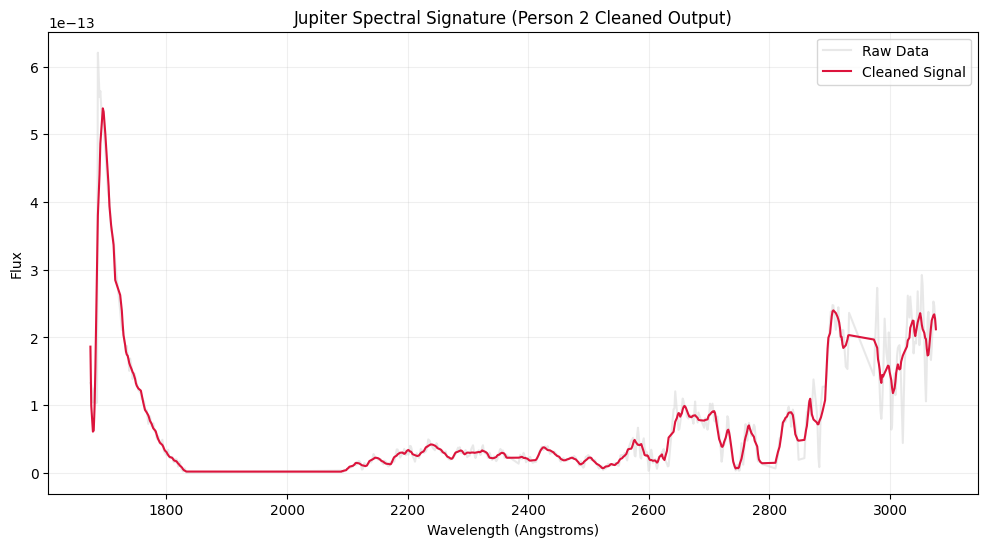

In [1]:
import numpy as np
import pandas as pd
from astropy.io import fits
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
import pickle

def process_jupiter_spectrum(file_path):
    print(f"🛠️  Cleaning File: {file_path}")
    
    with fits.open(file_path) as hdul:
        # SX1 data is in Extension 1
        data = hdul[1].data
        
        # 1. Extraction (SX1 usually uses WAVELENGTH and FLUX)
        wave = data['WAVELENGTH'].flatten()
        flux = data['FLUX'].flatten()
        dq = data['DQ'].flatten() # Data Quality flags
        
        # 2. Basic Cleaning: Remove 'bad' pixels
        # DQ == 0 is the gold standard for 'good data'
        mask = (dq == 0) & (flux > 0) # Also remove negative flux (physical noise)
        w_clean = wave[mask]
        f_clean = flux[mask]
        
        # 3. Smoothing: Savitzky-Golay Filter
        # This removes the 'fuzz' but keeps the chemical 'dips'
        # window_length must be odd. 11 or 15 is usually good for Jupiter.
        f_smooth = savgol_filter(f_clean, window_length=15, polyorder=3)
        
        return w_clean, f_clean, f_smooth

# --- EXECUTION ---
file_to_use = r"E:\DataFecked Hackathon\mastDownload\HST\o4ym01010\o4ym01010_sx1.fits"
wavelength, raw_flux, clean_flux = process_jupiter_spectrum(file_to_use)

# 4. Save as .pkl for the "Brain" Team (Squad B)
processed_data = {
    "target": "JUPITER",
    "wavelength": wavelength,
    "clean_flux": clean_flux,
    "unit_wave": "Angstroms",
    "unit_flux": "erg/s/cm2/A"
}

with open('cleaned_jupiter_spectrum.pkl', 'wb') as f:
    pickle.dump(processed_data, f)

print("✅ Data cleaned and saved to 'cleaned_jupiter_spectrum.pkl'")

# 5. Visual Check

plt.figure(figsize=(12, 6))
plt.plot(wavelength, raw_flux, color='lightgray', label='Raw Data', alpha=0.5)
plt.plot(wavelength, clean_flux, color='crimson', label='Cleaned Signal', linewidth=1.5)
plt.title("Jupiter Spectral Signature (Person 2 Cleaned Output)")
plt.xlabel("Wavelength (Angstroms)")
plt.ylabel("Flux")
plt.legend()
plt.grid(True, alpha=0.2)
plt.show()

🛠️  Cleaning File: E:\DataFecked Hackathon\mastDownload\HST\o4ym01020\o4ym01020_sx1.fits
✅ Data cleaned and saved to 'cleaned_jupiter_spectrum.pkl'


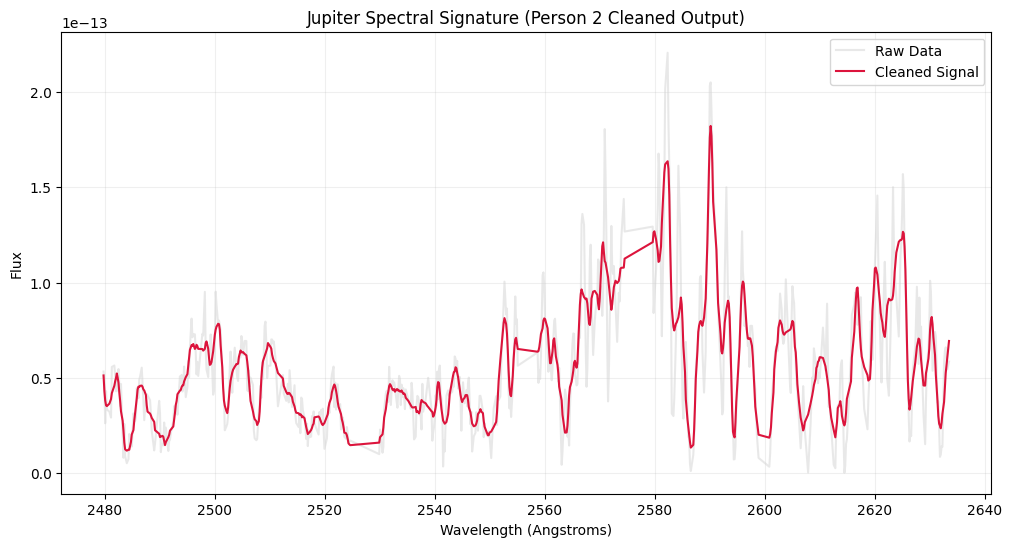

In [3]:
import numpy as np
import pandas as pd
from astropy.io import fits
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
import pickle

def process_jupiter_spectrum(file_path):
    print(f"🛠️  Cleaning File: {file_path}")
    
    with fits.open(file_path) as hdul:
        # SX1 data is in Extension 1
        data = hdul[1].data
        
        # 1. Extraction (SX1 usually uses WAVELENGTH and FLUX)
        wave = data['WAVELENGTH'].flatten()
        flux = data['FLUX'].flatten()
        dq = data['DQ'].flatten() # Data Quality flags
        
        # 2. Basic Cleaning: Remove 'bad' pixels
        # DQ == 0 is the gold standard for 'good data'
        mask = (dq == 0) & (flux > 0) # Also remove negative flux (physical noise)
        w_clean = wave[mask]
        f_clean = flux[mask]
        
        # 3. Smoothing: Savitzky-Golay Filter
        # This removes the 'fuzz' but keeps the chemical 'dips'
        # window_length must be odd. 11 or 15 is usually good for Jupiter.
        f_smooth = savgol_filter(f_clean, window_length=15, polyorder=3)
        
        return w_clean, f_clean, f_smooth

# --- EXECUTION ---
file_to_use = r"E:\DataFecked Hackathon\mastDownload\HST\o4ym01020\o4ym01020_sx1.fits"
wavelength, raw_flux, clean_flux = process_jupiter_spectrum(file_to_use)

# 4. Save as .pkl for the "Brain" Team (Squad B)
processed_data = {
    "target": "JUPITER",
    "wavelength": wavelength,
    "clean_flux": clean_flux,
    "unit_wave": "Angstroms",
    "unit_flux": "erg/s/cm2/A"
}

with open('cleaned_jupiter_spectrum.pkl', 'wb') as f:
    pickle.dump(processed_data, f)

print("✅ Data cleaned and saved to 'cleaned_jupiter_spectrum.pkl'")

# 5. Visual Check

plt.figure(figsize=(12, 6))
plt.plot(wavelength, raw_flux, color='lightgray', label='Raw Data', alpha=0.5)
plt.plot(wavelength, clean_flux, color='crimson', label='Cleaned Signal', linewidth=1.5)
plt.title("Jupiter Spectral Signature (Person 2 Cleaned Output)")
plt.xlabel("Wavelength (Angstroms)")
plt.ylabel("Flux")
plt.legend()
plt.grid(True, alpha=0.2)
plt.show()

🛠️  Cleaning File: E:\DataFecked Hackathon\mastDownload\HST\o4ym01030\o4ym01030_sx1.fits
✅ Data cleaned and saved to 'cleaned_jupiter_spectrum.pkl'


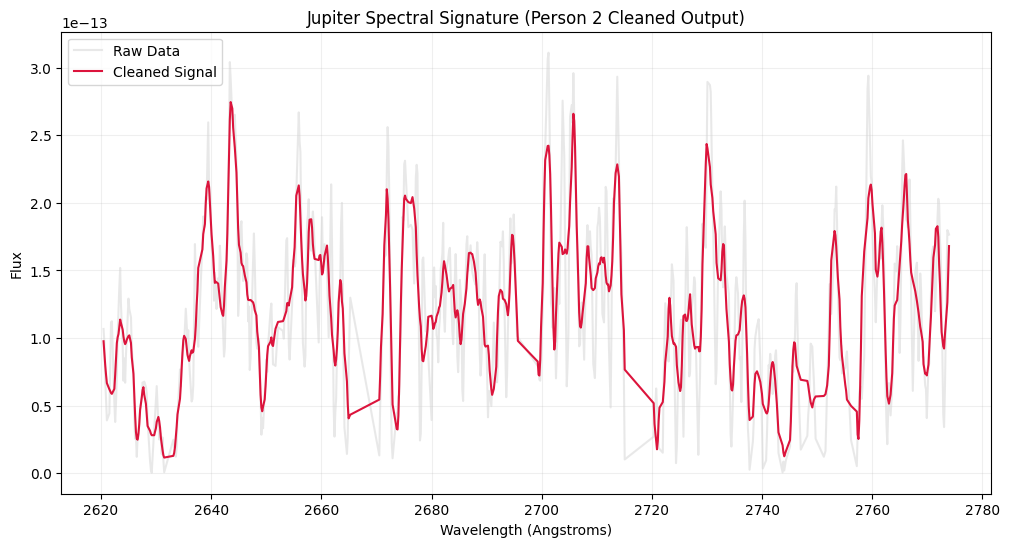

In [4]:
import numpy as np
import pandas as pd
from astropy.io import fits
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
import pickle

def process_jupiter_spectrum(file_path):
    print(f"🛠️  Cleaning File: {file_path}")
    
    with fits.open(file_path) as hdul:
        # SX1 data is in Extension 1
        data = hdul[1].data
        
        # 1. Extraction (SX1 usually uses WAVELENGTH and FLUX)
        wave = data['WAVELENGTH'].flatten()
        flux = data['FLUX'].flatten()
        dq = data['DQ'].flatten() # Data Quality flags
        
        # 2. Basic Cleaning: Remove 'bad' pixels
        # DQ == 0 is the gold standard for 'good data'
        mask = (dq == 0) & (flux > 0) # Also remove negative flux (physical noise)
        w_clean = wave[mask]
        f_clean = flux[mask]
        
        # 3. Smoothing: Savitzky-Golay Filter
        # This removes the 'fuzz' but keeps the chemical 'dips'
        # window_length must be odd. 11 or 15 is usually good for Jupiter.
        f_smooth = savgol_filter(f_clean, window_length=15, polyorder=3)
        
        return w_clean, f_clean, f_smooth

# --- EXECUTION ---
file_to_use = r"E:\DataFecked Hackathon\mastDownload\HST\o4ym01030\o4ym01030_sx1.fits"
wavelength, raw_flux, clean_flux = process_jupiter_spectrum(file_to_use)

# 4. Save as .pkl for the "Brain" Team (Squad B)
processed_data = {
    "target": "JUPITER",
    "wavelength": wavelength,
    "clean_flux": clean_flux,
    "unit_wave": "Angstroms",
    "unit_flux": "erg/s/cm2/A"
}

with open('cleaned_jupiter_spectrum.pkl', 'wb') as f:
    pickle.dump(processed_data, f)

print("✅ Data cleaned and saved to 'cleaned_jupiter_spectrum.pkl'")

# 5. Visual Check

plt.figure(figsize=(12, 6))
plt.plot(wavelength, raw_flux, color='lightgray', label='Raw Data', alpha=0.5)
plt.plot(wavelength, clean_flux, color='crimson', label='Cleaned Signal', linewidth=1.5)
plt.title("Jupiter Spectral Signature (Person 2 Cleaned Output)")
plt.xlabel("Wavelength (Angstroms)")
plt.ylabel("Flux")
plt.legend()
plt.grid(True, alpha=0.2)
plt.show()

In [11]:
import os
os.chdir("E:\\DataFecked Hackathon\\Jupiter - mastDownload\\Merged File")
os.getcwd()

'E:\\DataFecked Hackathon\\Jupiter - mastDownload\\Merged File'

In [13]:
import numpy as np
from astropy.io import fits
from scipy.signal import savgol_filter
import pickle

def clean_and_grid(file_path, target_wave):
    with fits.open(file_path) as hdul:
        data = hdul[1].data
        wave, flux, dq = data['WAVELENGTH'].flatten(), data['FLUX'].flatten(), data['DQ'].flatten()
        # Clean bad pixels
        mask = (dq == 0) & (flux > 0)
        # Interpolate onto the master grid so we can average them
        flux_interp = np.interp(target_wave, wave[mask], flux[mask], left=0, right=0)
        return flux_interp

# 1. Define your files
files = [
    r"E:\DataFecked Hackathon\Jupiter - mastDownload\HST\o4ym01010\o4ym01010_sx1.fits",
    r"E:\DataFecked Hackathon\Jupiter - mastDownload\HST\o4ym01020\o4ym01020_sx1.fits",
    r"E:\DataFecked Hackathon\Jupiter - mastDownload\HST\o4ym01030\o4ym01030_sx1.fits"
]

# 2. Create a master wavelength grid (based on the first file)
with fits.open(files[0]) as h:
    master_wave = h[1].data['WAVELENGTH'].flatten()

# 3. Process and Average
all_fluxes = [clean_and_grid(f, master_wave) for f in files]
average_flux = np.mean(all_fluxes, axis=0)
final_smooth = savgol_filter(average_flux, window_length=15, polyorder=3)

# 4. SAVE THE ONE FILE FOR THE BRAIN TEAM
master_data = {
    "target": "JUPITER",
    "wavelength": master_wave,
    "flux": final_smooth,
    "notes": "Averaged 010, 020, 030 SX1 files. UV range."
}

with open('JUPITER_MASTER_SPECTRA.pkl', 'wb') as f:
    pickle.dump(master_data, f)

print("🚀 DONE! Send 'JUPITER_MASTER_SPECTRA.pkl' to the Brain Team.")

🚀 DONE! Send 'JUPITER_MASTER_SPECTRA.pkl' to the Brain Team.


In [63]:
import pickle
with open('JUPITER_MASTER_SPECTRA.pkl', 'rb') as f:
    df = pd.read_pickle(f)
df
# data['flux'] is now the clean line for their LLM prompt!

{'target': 'JUPITER',
 'wavelength': array([1672.65743539, 1674.02808817, 1675.39875648, ..., 3074.53802762,
        3075.90790125, 3077.27775782]),
 'flux': array([3.65827507e-14, 2.43624703e-14, 1.88089110e-14, ...,
        6.25247291e-14, 4.75429220e-14, 2.68720051e-14]),
 'notes': 'Averaged 010, 020, 030 SX1 files. UV range.'}

### InfraRed Data

In [59]:
import numpy as np
import pickle
import matplotlib.pyplot as plt

def process_ir_fits_to_pkl(fits_filename, output_pkl):
    """
    Universally reads IRTF/SpeX style FITS, cleans, and saves to .pkl
    """
    # Open binary FITS to avoid dependency issues
    with open(fits_filename, 'rb') as f:
        # 1. Skip Header (Search for 'END')
        header_content = b""
        while b'END     ' not in header_content:
            header_content += f.read(2880)
        
        # 2. Find dimensions (Assume 32-bit float, NAXIS1 x NAXIS2)
        # For IRTF: Row 0 = Wave, Row 1 = Flux, Row 2 = Error
        # Adjust naxis1/naxis2 based on your specific FITS header if needed
        data = np.frombuffer(f.read(), dtype='>f4')
        naxis1 = 4165 # Standard IRTF length; update if different
        data = data[:naxis1*3].reshape((3, naxis1))
        
        wave = data[0].byteswap().newbyteorder().astype(float)
        flux = data[1].byteswap().newbyteorder().astype(float)
        
        # 3. Cleaning: Remove non-finite (NaN) and non-physical (Negative) flux
        mask = np.isfinite(flux) & (flux > 0)
        clean_wave = wave[mask]
        clean_flux = flux[mask]
        
        # 4. Save to PKL
        master_data = {'wave': clean_wave, 'flux': clean_flux}
        with open(output_pkl, 'wb') as pkl_file:
            pickle.dump(master_data, pkl_file)
        
        print(f"Successfully created {output_pkl}")
        return clean_wave, clean_flux

# Example Usage:
ir_wave, ir_flux = process_ir_fits_to_pkl('uranus_spectrum_irtf.fits', 'URANUS_IR_MASTER.pkl')

Successfully created URANUS_IR_MASTER.pkl


✅ Success: SATURN IR Master File saved to SATURN_IR_MASTER.pkl


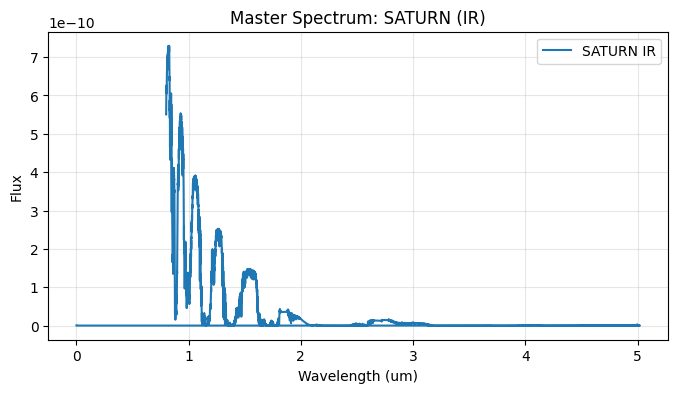

In [69]:
import numpy as np
import pickle
import pandas as pd
import matplotlib.pyplot as plt

def create_planet_master(fits_filename, planet_name, observation_type, output_pkl):
    """
    fits_filename: Path to your FITS file
    planet_name: 'URANUS', 'JUPITER', etc.
    observation_type: 'IR' or 'UV'
    """
    
    # 1. MANUALLY READ FITS (Safe for all environments)
    with open(fits_filename, 'rb') as f:
        header_content = b""
        while b'END     ' not in header_content:
            header_content += f.read(2880)
        
        # Read the raw data buffer
        raw_data = np.frombuffer(f.read(), dtype='>f4')
        
        # IRTF Data standard: 3 rows (Wave, Flux, Error)
        # Note: If your next planet FITS has a different length, 
        # you can adjust naxis1 or use raw_data.reshape(3, -1)
        n_points = len(raw_data) // 3
        data = raw_data[:n_points*3].reshape((3, n_points))
        
        # Convert to little-endian for Python processing
        wave = data[0].byteswap().newbyteorder().astype(float)
        flux = data[1].byteswap().newbyteorder().astype(float)

    # 2. DATA CLEANING
    # Remove NaNs, infinities, and non-physical negative flux
    mask = np.isfinite(flux) & (flux > 0)
    clean_wave = wave[mask]
    clean_flux = flux[mask]

    # 3. BUILD THE UNIVERSAL DICTIONARY
    master_data = {
        'target_name': planet_name.upper(),
        'obs_type': observation_type.upper(),
        'wave': clean_wave,
        'flux': clean_flux,
        'wave_unit': 'um' if observation_type.upper() == 'IR' else 'Angstrom',
        'timestamp': '2000-05-18' # You can extract this from header if needed
    }

    # 4. SAVE TO PKL
    with open(output_pkl, 'wb') as pkl_file:
        pickle.dump(master_data, pkl_file)
    
    print(f"✅ Success: {planet_name} {observation_type} Master File saved to {output_pkl}")
    
    # 5. AUTO-PLOT FOR VALIDATION
    plt.figure(figsize=(8, 4))
    plt.plot(clean_wave, clean_flux, label=f"{planet_name} {observation_type}")
    plt.title(f"Master Spectrum: {planet_name} ({observation_type})")
    plt.xlabel(f"Wavelength ({master_data['wave_unit']})")
    plt.ylabel("Flux")
    plt.grid(alpha=0.3)
    plt.legend()
    plt.show()

    return master_data

# --- HOW TO USE FOR URANUS ---
#uranus_ir = create_planet_master('uranus_spectrum_irtf.fits', 'URANUS', 'IR', 'URANUS_IR_MASTER.pkl')

# --- HOW TO USE FOR JUPITER (Next) ---
saturn_ir = create_planet_master('saturn_spectrum_irtf.fits', 'SATURN', 'IR', 'SATURN_IR_MASTER.pkl')

In [61]:
import pickle
with open('URANUS_IR_MASTER.pkl', 'rb') as f:
    df = pd.read_pickle(f)
df

{'wave': array([0.8204515 , 0.82065904, 0.82086653, ..., 2.47278595, 2.47389078,
        2.4744432 ]),
 'flux': array([1.20013877e-11, 1.18565253e-11, 1.21464245e-11, ...,
        2.37249482e-16, 7.40510677e-15, 4.66975320e-15])}

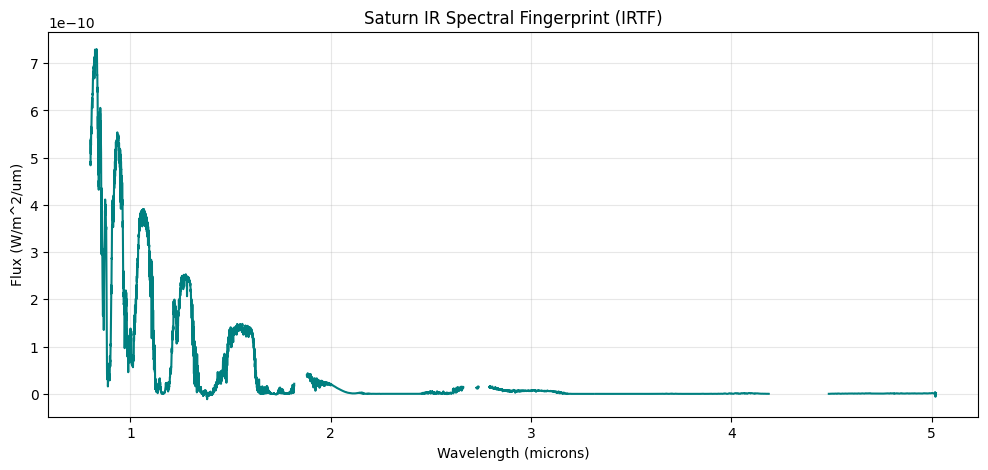

In [71]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np

# 1. Open the IRTF Uranus File
with fits.open('saturn_spectrum_irtf.fits') as hdul:
    data = hdul[0].data
    header = hdul[0].header
    # In IRTF files, Row 0 is Wavelength (um), Row 1 is Flux, Row 2 is Uncertainty
    wave_ir = data[0]
    flux_ir = data[1]

# 2. Plotting the IR Signature
plt.figure(figsize=(12, 5))
plt.plot(wave_ir, flux_ir, color='teal', label='Saturn IR (Composition)')
plt.title("Saturn IR Spectral Fingerprint (IRTF)")
plt.xlabel("Wavelength (microns)")
plt.ylabel("Flux (W/m^2/um)")
plt.grid(alpha=0.3)
plt.show()

In [70]:
import pickle
import numpy as np
import pandas as pd

def generate_image_team_guide(planet_name, uv_pkl_path, ir_pkl_path):
    """
    Combines IR Dips and UV Peaks into a search strategy for the Image Team.
    """
    results = []

    # 1. Process IR Data (Looking for Dips)
    with open(ir_pkl_path, 'rb') as f:
        ir_data = pickle.load(f)
    
    # Define standard Methane search zones
    ir_zones = [
        (1.1, 1.2, "Methane Band 1 (Deep Cloud)"),
        (1.3, 1.5, "Methane Band 2 (Storm Layer)"),
        (1.6, 2.5, "Primary Methane Absorption (Rings/Storms)")
    ]
    
    for low, high, science in ir_zones:
        mask = (ir_data['wave'] >= low) & (ir_data['wave'] <= high)
        if np.any(mask):
            # Find the absolute lowest flux in this zone
            idx_min = np.argmin(ir_data['flux'][mask])
            wave_val = ir_data['wave'][mask][idx_min]
            results.append({
                'Planet': planet_name,
                'Spectrum': 'IR',
                'Feature': 'DIP (Minimum)',
                'Wavelength': f"{wave_val:.3f} um",
                'Science_Goal': science,
                'Recommended_PDS_Filter': 'ch4_u / ch4_js'
            })

    # 2. Process UV Data (Looking for Peaks)
    with open(uv_pkl_path, 'rb') as f:
        uv_data = pickle.load(f)
        
    uv_zones = [
        (1200, 1600, "Auroral Emission Lines"),
        (2000, 2600, "High-Altitude Haze")
    ]

    for low, high, science in uv_zones:
        mask = (uv_data['wave'] >= low) & (uv_data['wave'] <= high)
        if np.any(mask):
            # Find the absolute highest flux in this zone
            idx_max = np.argmax(uv_data['flux'][mask])
            wave_val = uv_data['wave'][mask][idx_max]
            results.append({
                'Planet': planet_name,
                'Spectrum': 'UV',
                'Feature': 'PEAK (Maximum)',
                'Wavelength': f"{wave_val:.1f} Å",
                'Science_Goal': science,
                'Recommended_PDS_Filter': 'uv / violet'
            })

    # 3. Create the Guide
    df_guide = pd.DataFrame(results)
    output_name = f"{planet_name}_search_guide.csv"
    df_guide.to_csv(output_name, index=False)
    
    print(f"--- {planet_name} IMAGE SEARCH STRATEGY ---")
    print(df_guide.to_string(index=False))
    return df_guide

# --- EXECUTION ---
guide = generate_image_team_guide('SATURN', 'SATURN_UV_MASTER.pkl', 'SATURN_IR_MASTER.pkl')

--- SATURN IMAGE SEARCH STRATEGY ---
Planet Spectrum        Feature Wavelength                              Science_Goal Recommended_PDS_Filter
SATURN       IR  DIP (Minimum)   1.156 um               Methane Band 1 (Deep Cloud)         ch4_u / ch4_js
SATURN       IR  DIP (Minimum)   1.378 um              Methane Band 2 (Storm Layer)         ch4_u / ch4_js
SATURN       IR  DIP (Minimum)   2.213 um Primary Methane Absorption (Rings/Storms)         ch4_u / ch4_js
SATURN       UV PEAK (Maximum)   1586.3 Å                    Auroral Emission Lines            uv / violet
SATURN       UV PEAK (Maximum)   2235.4 Å                        High-Altitude Haze            uv / violet
